# Operations on Word Vectors

Welcome to your first assignment of Week 2, Course 5 of the Deep Learning Specialization! 

Because word embeddings are very computationally expensive to train, most ML practitioners will load a pre-trained set of embeddings. In this notebook you'll try your hand at loading, measuring similarity between, and modifying pre-trained embeddings. 

## Libarys

In [1]:
import numpy as np
import pandas as pd
from utils.similarity_utils.w2v_utils import *

## Embedding Vectors Versus One-Hot Vectors
One-hot vectors don't do a good job of capturing the level of similarity between words. This is because every one-hot vector has the same Euclidean distance from any other one-hot vector.

Embedding vectors, such as [GloVe vectors](https://nlp.stanford.edu/projects/glove/), provide much more useful information about the meaning of individual words.  

In [2]:
words, word_to_vec_map = read_glove_vecs('../datasets/texts/glove.6B.50d.txt')

## Cosine Similarity

To measure the similarity between two words, you need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$. 
* The cosine similarity depends on the angle between $u$ and $v$. 
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value. 

<center><img src="images/cosine_sim.png" style="width:800px;height:250px;"></center>
<caption><center><font color='purple'><b>Figure 1</b>: The cosine of the angle between two vectors is a measure of their similarity.</font></center></caption>

In [3]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    # Special case. Consider the case u = [0, 0], v=[0, 0]
    if np.all(u == v):
        return 1
    
    # Compute the dot product between u and v
    dot = np.dot(u, v) 
    norm_u = np.sqrt(np.sum(np.power(u, 2)))
    
    norm_v = np.linalg.norm(v)
    
    # Avoid division by 0
    if np.isclose(norm_u * norm_v, 0, atol=1e-32):
        return 0
    
    # Compute the cosine similarity defined by formula (1) 
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

## Word Analogy Task

* In the word analogy task, complete this sentence:  
    <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>. 

* An example is:  
    <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>. 

* You're trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner:   
    $e_b - e_a \approx e_d - e_c$
* Measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 

<a name='ex-2'></a>

In [4]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lowercase
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # Get the word embeddings e_a, e_b and e_c
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output
    
    # loop over the whole word vector set
    for w in words:   
        # to avoid best_word being one the input words, skip the input word_c
        # skip word_c from query
        if w == word_c:
            continue
        
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w 

    return best_word

## Applying

In [5]:
triads_to_try = [('italy', 'italian', 'spain'),
                 ('india', 'delhi', 'japan'),
                 ('man', 'woman', 'boy'),
                 ('small', 'smaller', 'large')]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad, word_to_vec_map)))


italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> smaller


*Conclusion*

- Cosine similarity is a good way to compare the similarity between pairs of word vectors.
    - Note that L2 (Euclidean) distance also works.
- For NLP applications, using a pre-trained set of word vectors is often a great way to get started. 

## Debiasing Word Vectors

We'll examine gender biases that can be reflected in a word embedding, and explore algorithms for reducing the bias.

First, let's see how the [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/) relate to gender, beginning by computing a vector $g = e_{woman}-e_{man}$, where $e_{woman}$ represents the word vector corresponding to the word *woman*, and $e_{man}$ corresponds to the word vector corresponding to the word *man*. The resulting vector $g$ roughly encodes the concept of "gender". 

We might get a more accurate representation if you compute $g_1 = e_{mother}-e_{father}$, $g_2 = e_{girl}-e_{boy}$, etc. and average over them, but just using $e_{woman}-e_{man}$ will give good enough results for now.

In [6]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [7]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.3186878985941878
ronaldo -0.31244796850329437
priya 0.17632041839009402
rahul -0.16915471039231722
danielle 0.24393299216283895
reza -0.07930429672199553
katy 0.2831068659572615
yasmin 0.23313857767928753


Female first names tend to have a positive cosine similarity with our constructed vector $g$, while male first names tend to have a negative cosine similarity. This is not surprising, and the result seems acceptable. 

In [8]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.27691916256382665
guns -0.1888485567898898
science -0.06082906540929699
arts 0.008189312385880344
literature 0.0647250443345993
warrior -0.20920164641125288
doctor 0.11895289410935045
tree -0.07089399175478092
receptionist 0.3307794175059374
technology -0.13193732447554293
fashion 0.035638946257727
teacher 0.1792092343182567
engineer -0.08039280494524072
pilot 0.0010764498991917074
computer -0.10330358873850498
singer 0.18500518136496297


Do you notice anything surprising? It is astonishing how these results reflect certain unhealthy gender stereotypes. For example, we see “computer” is negative and is closer in value to male first names, while “literature” is positive and is closer to female first names.

We will reduce the bias of these vectors, using an algorithm due to [Boliukbasi et al., 2016](https://arxiv.org/abs/1607.06520). Note that some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender-specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related.

### Neutralize Bias for Non-Gender Specific Words

The figure below should help you visualize what neutralizing does. If you're using a 50-dimensional word embedding, the 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which is called $g_{\perp}$ here. In linear algebra, we say that the 49-dimensional $g_{\perp}$ is perpendicular (or "orthogonal") to $g$, meaning it is at 90 degrees to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$. 

Even though $g_{\perp}$ is 49-dimensional, given the limitations of what you can draw on a 2D screen, it's illustrated using a 1-dimensional axis below. 

<center><img src="images/neutral.png" style="width:800px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 2</b>: The word vector for "receptionist" represented before and after applying the neutralize operation.</font> </center></caption>

The function `neutralize()` will remove the bias of words such as "receptionist" or "scientist."

Given an input embedding $e$, we can use the following formulas to compute $e^{debiased}$: 

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$
$$e^{debiased} = e - e^{bias\_component}\tag{3}$$

The $e^{bias\_component}$ is the projection of $e$ onto the direction $g$.

**Note:** The [paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf), which the debiasing algorithm is from, assumes all word vectors to have L2 norm as 1 and hence the need for the calculations below:

In [9]:
# The paper assumes all word vectors to have L2 norm as 1 and hence the need for this calculation
from tqdm import tqdm
word_to_vec_map_unit_vectors = {
    word: embedding / np.linalg.norm(embedding)
    for word, embedding in tqdm(word_to_vec_map.items())
}
g_unit = word_to_vec_map_unit_vectors['woman'] - word_to_vec_map_unit_vectors['man']

  0%|          | 0/400000 [00:00<?, ?it/s]

100%|██████████| 400000/400000 [00:01<00:00, 316436.85it/s]


In [10]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    # Select word vector representation of "word". Use word_to_vec_map.
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula given above.
    e_biascomponent = np.dot(e, g) * g / np.linalg.norm(g)**2
 
    # Neutralize e by subtracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection.
    e_debiased = e - e_biascomponent
    
    return e_debiased

In [11]:
word = "receptionist"
print("cosine similarity between " + word + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map[word], g))

e_debiased = neutralize(word, g_unit, word_to_vec_map_unit_vectors)
print("cosine similarity between " + word + " and g_unit, after neutralizing: ", cosine_similarity(e_debiased, g_unit))

cosine similarity between receptionist and g, before neutralizing:  0.3307794175059374
cosine similarity between receptionist and g_unit, after neutralizing:  2.0560779843378157e-17


The second result is essentially 0, up to numerical rounding (on the order of 10−17). We can conclude that the neutralization was successful.

### Equalization Algorithm for Gender-Specific Words

Next, let's see how debiasing can also be applied to word pairs such as "actress" and "actor." Equalization is applied to pairs of words that you might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralization to "babysit," you can reduce the gender stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this. 

The key idea behind equalization is to make sure that a particular pair of words are equidistant from the 49-dimensional $g_\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e_{receptionist}^{debiased}$, or from any other work that has been neutralized. Visually, this is how equalization works: 

<center>
<img src="images/equalize10.png" style="width:800px;height:400px;">
</center>

The derivation of the linear algebra to do this is a bit more complex. (See Bolukbasi et al., 2016 in the References for details.) Here are the key equations: 


$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$ 

$$ \mu_{B} = \frac{\mu \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis}
\tag{5} $$ 

$$ \mu_{\perp} = \mu - \mu_{B} \tag{6}$$

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis}
\tag{7}$$ 
$$ e_{w2B} = \frac {e_{w2} \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis}
\tag{8}$$

$$e_{w1B}^{corrected} = \sqrt{{1 - ||\mu_{\perp} ||^2_2}} * \frac{e_{\text{w1B}} - \mu_B} {||e_{w1B} - \mu_B||_2} \tag{9}$$


$$e_{w2B}^{corrected} = \sqrt{{1 - ||\mu_{\perp} ||^2_2}} * \frac{e_{\text{w2B}} - \mu_B} {||e_{w2B} - \mu_B||_2} \tag{10}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{11} $$
$$ e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{12} $$

In [12]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    # Step 1: Select word vector representation of "word". Use word_to_vec_map.
    w1, w2 = pair[0], pair[1]
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    
    # Step 2: Compute the mean of e_w1 and e_w2
    mu = (e_w1 + e_w2) / 2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis
    mu_B = np.dot(mu, bias_axis) * bias_axis / np.linalg.norm(bias_axis)**2
    mu_orth = mu - mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B
    e_w1B = np.dot(e_w1, bias_axis) * bias_axis / np.linalg.norm(bias_axis)**2
    e_w2B = np.dot(e_w2, bias_axis) * bias_axis / np.linalg.norm(bias_axis)**2
        
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above
    corrected_e_w1B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth)**2)) * (e_w1B - mu_B) /np.linalg.norm(e_w1B - mu_B)
    corrected_e_w2B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth)**2)) * (e_w2B - mu_B) /np.linalg.norm(e_w2B - mu_B)

    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2

In [13]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g_unit, word_to_vec_map_unit_vectors)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g_unit))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g_unit))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.23871136142883811
cosine_similarity(e2, gender) =  0.23871136142883814


These debiasing algorithms are very helpful for reducing bias, but aren't perfect and don't eliminate all traces of bias. For example, one weakness of this implementation was that the bias direction $g$ was defined using only the pair of words _woman_ and _man_. As discussed earlier, if $g$ were defined by computing $g_1 = e_{woman} - e_{man}$; $g_2 = e_{mother} - e_{father}$; $g_3 = e_{girl} - e_{boy}$; and so on and averaging over them, you would obtain a better estimate of the "gender" dimension in the 50 dimensional word embedding space.

# Emojify! 

We'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, you need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* You can make a more flexible emoji interface by using word vectors!
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

In [14]:
import emoji
%matplotlib inline

In [15]:
X_train, Y_train = read_csv('../datasets/emoji/train_emoji.csv')
X_test, Y_test = read_csv('../datasets/emoji/test_emoji.csv')

In [16]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [17]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again :disappointed:
I am proud of your achievements :smile:
It is the worst day in my life :disappointed:
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit :disappointed:
congratulations on your acceptance :smile:
The assignment is too long  :disappointed:
I want to go play ⚾


### Overview of the Emojifier-V1

In this section, you'll implement a baseline model called "Emojifier-v1".  

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* To get your labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [18]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [19]:
idx = 55
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'This is so funny' has label index 2, which is emoji :smile:
Label index 2 in one-hot encoding format is [0. 0. 1. 0. 0.]


### Implementing Emojifier-V1

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors. 

Similar to this week's previous assignment, you'll use pre-trained 50-dimensional GloVe embeddings. 

Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [20]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../datasets/texts/glove.6B.50d.txt', rtr='all')

- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [21]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [22]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = next(iter(word_to_vec_map.keys()))
    
    # Step 1: Split sentence into list of lower case word 
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    # Use `np.zeros` and pass in the argument of any word's word 2 vec's shape
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg /= count
        
    return avg

To predict we have this function.

In [23]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        
        if count > 0:
            avg = avg / count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

Now to implement the model we will use this equations:

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note**: It is possible to come up with a more efficient vectorized implementation. For now, just use nested for loops to better understand the algorithm, and for easier debugging.

In [24]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = next(iter(word_to_vec_map.keys()))
        
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        
        cost = 0
        dW = 0
        db = 0
        
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            # Use 'sentence_to_avg' you implemented above for this  
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer. 
            # You can use np.dot() to perform the multiplication.
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Add the cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += - np.sum(Y_oh[i] * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W -= learning_rate * dW
            b -= learning_rate * db
            
        if t % 10 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)
        
    return pred, W, b

#### Training and testing

In [25]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map, learning_rate=0.0001)

Epoch: 0 --- cost = 232.9436445320156
Accuracy: 0.30303030303030304
Epoch: 10 --- cost = 142.17512521386914
Accuracy: 0.6818181818181818
Epoch: 20 --- cost = 115.04016662609867
Accuracy: 0.7803030303030303
Epoch: 30 --- cost = 100.4563632630671
Accuracy: 0.8106060606060606
Epoch: 40 --- cost = 90.86402038868474
Accuracy: 0.8257575757575758
Epoch: 50 --- cost = 83.86603787600993
Accuracy: 0.8409090909090909
Epoch: 60 --- cost = 78.43179786082334
Accuracy: 0.8484848484848485
Epoch: 70 --- cost = 74.03301475416161

In [26]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5454545454545454
Test set:
Accuracy: 0.35714285714285715


In [27]:
X_my_sentences = np.array(["i treasure you", "i love you", "funny lol", "lets play with a ball", "food is ready", "today is not good"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.3333333333333333

i treasure you :disappointed:
i love you :smile:
funny lol :smile:
lets play with a ball ⚾
food is ready :disappointed:
today is not good :smile:


(56,)
           ❤️    ⚾    :smile:    :disappointed:   🍴
Predicted  1.0  2.0  3.0  All
Actual                       
0            0    6    6   12
1            2    3    0    5
2            0   10    8   18
3            0    7    8   15
4            0    2    4    6
All          2   28   26   56


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (6).

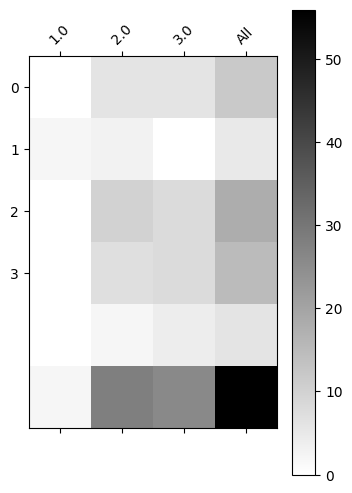

In [28]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)